In [ ]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """

   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style('rise.css')

# More molecular dynamics

<a href="?print-pdf">print view</a>  
<a href="lecture-15-md2.ipynb" download>notebook</a>

## MDAnalysis Review

In [2]:
import MDAnalysis
from MDAnalysis.analysis.rms import *  #this pulls in an rmsd function

universe = MDAnalysis.Universe('shmt2.prmtop', 'shmt2.dcd')
prot = universe.select_atoms('protein')

startref = prot.positions
universe.trajectory[-1]
endref = prot.positions  

startrmsd = []
endrmsd = []
for ts in universe.trajectory:
    startrmsd.append(rmsd(startref,prot.positions))
    endrmsd.append(rmsd(endref,prot.positions))


C:\Users\mertg\anaconda3\lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


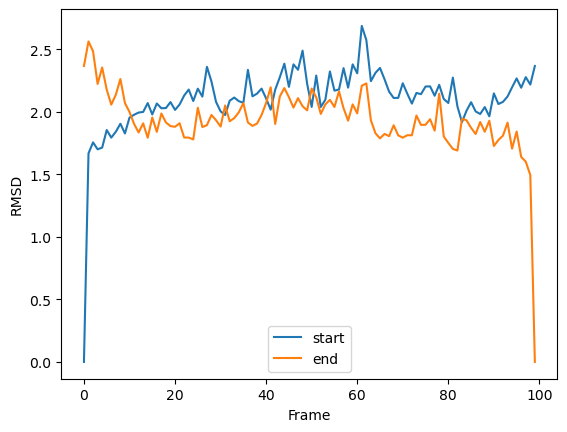

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(startrmsd,label='start')
plt.plot(endrmsd,label='end')
plt.legend(loc='lower center')
plt.ylabel('RMSD')
plt.xlabel("Frame");

## Next assignment

Calculate rmsds between frames.

<img src="https://asinansaglam.github.io/python_bio_2022/files/1ENH.png" width="600">

<img src="https://asinansaglam.github.io/python_bio_2022/files/1ubq.png">

## MDAnalysis.analysis.contacts


Analysis of native contacts q over a trajectory.

* a “contact” exists between two atoms *i* and *j* if the distance between them is smaller than a given radius
* a “native contact” exists between *i* and *j* if a contact exists and if the contact also exists between the equivalent atoms in a reference structure or conformation

What counts as a contact?
1. Hard Cut: To count as a contact the atoms *i* and *j* have to be at least as close as in the reference structure.
2. Soft Cut: The atom pair *i* and *j* is assigned based on a soft potential ($\lambda = 1.8$ and $\beta = 5.0$ by default)
$$Q(r, r_0) = \frac{1}{1 + e^{\beta (r - \lambda r_0)}}$$
3. Radius Cut: To count as a contact the atoms *i* and *j* cannot be further apart then some distance radius.



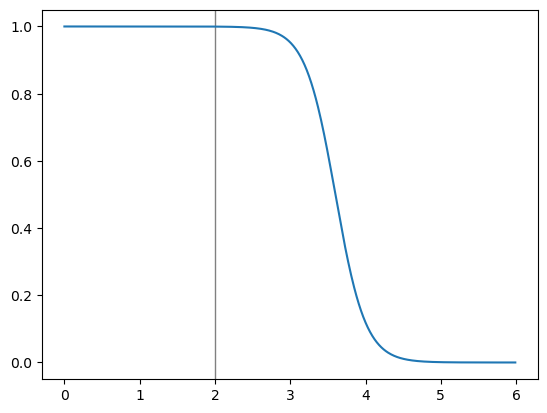

In [4]:
x = np.arange(0.0, 6.0, 0.01)
y = 1.0/(1.0 + np.exp(5.0*(x-1.8*2)))
plt.axvline(2,color='grey',linewidth=1)
plt.plot(x,y);

In [5]:
from MDAnalysis.analysis.contacts import *

help(MDAnalysis.analysis.contacts.Contacts)

Help on class Contacts in module MDAnalysis.analysis.contacts:

class Contacts(MDAnalysis.analysis.base.AnalysisBase)
 |  Contacts(u, select, refgroup, method='hard_cut', radius=4.5, pbc=True, kwargs=None, **basekwargs)
 |  
 |  Calculate contacts based observables.
 |  
 |  The standard methods used in this class calculate the fraction of native
 |  contacts *Q* from a trajectory.
 |  
 |  
 |  .. rubric:: Contact API
 |  
 |  By defining your own method it is possible to calculate other observables
 |  that only depend on the distances and a possible reference distance. The
 |  **Contact API** prescribes that this method must be a function with call
 |  signature ``func(r, r0, **kwargs)`` and must be provided in the keyword
 |  argument `method`.
 |  
 |  Attributes
 |  ----------
 |  results.timeseries : numpy.ndarray
 |      2D array containing *Q* for all refgroup pairs and analyzed frames
 |  
 |  timeseries : numpy.ndarray
 |      Alias to the :attr:`results.timeseries` attribut

C:\Users\mertg\anaconda3\lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


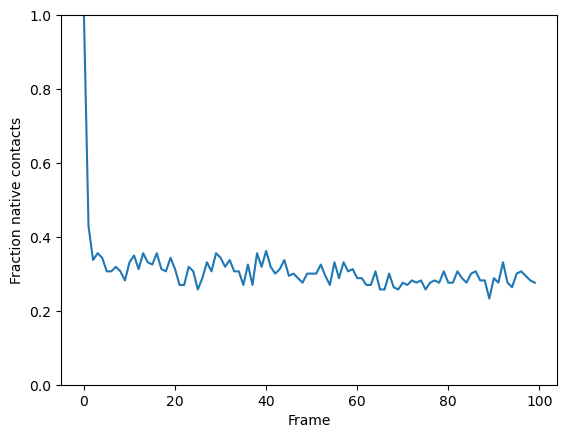

In [6]:
import MDAnalysis
from MDAnalysis.analysis.contacts import *

u = MDAnalysis.Universe('shmt2.prmtop','shmt2.dcd')
sel_basic = "(resname ARG or resname LYS) and (name NH* or name NZ)"
sel_acidic = "(resname ASP or resname GLU) and (name OE* or name OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

CA = Contacts(u, select=(sel_acidic, sel_basic), refgroup=(acidic, basic))
CA.run()

plt.plot(CA.results.timeseries[:, 0], CA.results.timeseries[:, 1])
plt.ylim(0,1)
plt.xlabel("Frame"); plt.ylabel("Fraction native contacts");

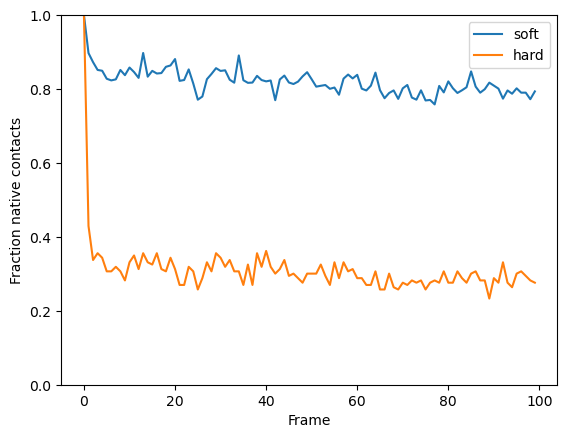

In [7]:
CAsoft = Contacts(u, select=(sel_acidic, sel_basic), refgroup=(acidic, basic),method='soft_cut')
CAsoft.run()

plt.plot(CAsoft.results.timeseries[:, 0], CAsoft.results.timeseries[:, 1],label="soft")
plt.plot(CA.results.timeseries[:, 0], CA.results.timeseries[:, 1],label="hard")
plt.legend(loc='best')
plt.ylim(0,1)
plt.xlabel("Frame"); plt.ylabel("Fraction native contacts");

## MDAnalysis.analysis.distances

Analysis of distances between groups of atoms.  Precursor to contact analysis.

In [8]:
from MDAnalysis.analysis.distances import *

distarr = distance_array(acidic.positions,basic.positions)

In [9]:
import MDAnalysis.analysis.distances
help(MDAnalysis.analysis.distances.distance_array)

Help on function distance_array in module MDAnalysis.lib.distances:

distance_array(reference: Union[numpy.ndarray[Any, numpy.dtype[+ScalarType]], ForwardRef('AtomGroup')], configuration: Union[numpy.ndarray[Any, numpy.dtype[+ScalarType]], ForwardRef('AtomGroup')], box: Optional[numpy.ndarray[Any, numpy.dtype[+ScalarType]]] = None, result: Optional[numpy.ndarray[Any, numpy.dtype[+ScalarType]]] = None, backend: str = 'serial') -> numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]
    Calculate all possible distances between a reference set and another
    configuration.
    
    If there are ``n`` positions in `reference` and ``m`` positions in
    `configuration`, a distance array of shape ``(n, m)`` will be computed.
    
    If the optional argument `box` is supplied, the minimum image convention is
    applied when calculating distances. Either orthogonal or triclinic boxes are
    supported.
    
    If a 2D numpy array of dtype ``numpy.float64`` with the shape ``(n, m)``
    is p

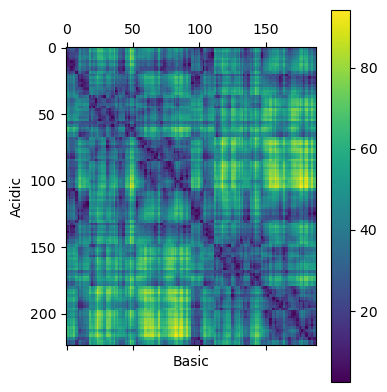

In [10]:
plt.matshow(distarr)
plt.colorbar()
plt.xlabel('Basic'); plt.ylabel('Acidic');

## Distance analysis

Really only interested in short distances

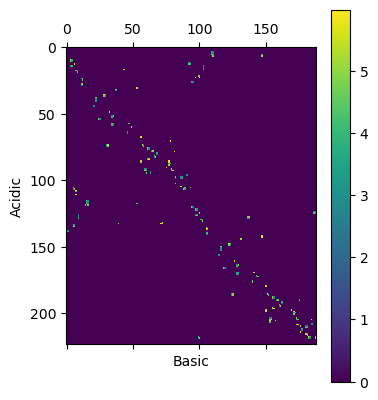

In [12]:
origdistarr = distance_array(acidic.positions,basic.positions)
origdistarr[origdistarr > 6] = 0
plt.matshow(origdistarr)
plt.colorbar()
plt.xlabel('Basic'); plt.ylabel('Acidic');

## Analyzing across the trajectory

In [13]:
distarr = np.zeros((acidic.n_atoms, basic.n_atoms))
for ts in u.trajectory:
    distarr += distance_array(acidic.positions,basic.positions)
distarr /= universe.trajectory.n_frames

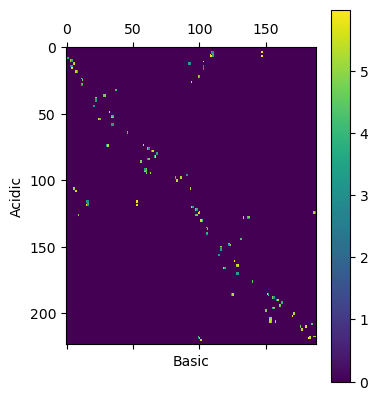

In [14]:
distarr[distarr > 6] = 0
plt.matshow(distarr)
plt.colorbar()
plt.xlabel('Basic'); plt.ylabel('Acidic');

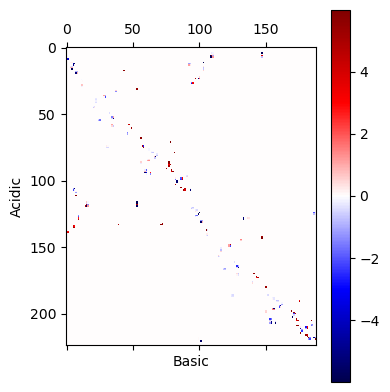

In [16]:
diff = origdistarr - distarr
plt.matshow(diff,cmap='seismic')
clb = plt.colorbar()
clb.set_label('')
plt.xlabel('Basic'); plt.ylabel('Acidic');

I'm most interested in the loop from residue 368 to 383 (`resid 368:383`).

How is this loop changing over the course of the simulation (RMSD to first)?

What is happening with the number of hydrogen bonds it is making with the protein?

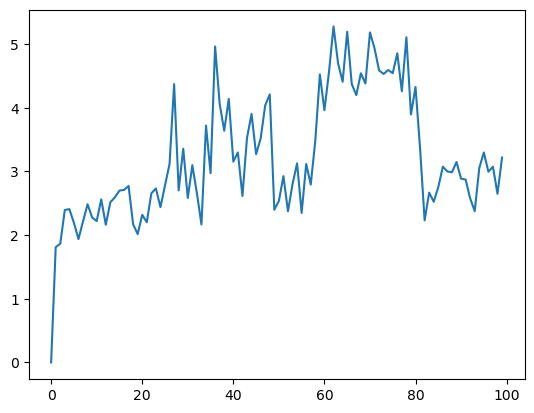

In [17]:
u.trajectory[0]
loop = u.select_atoms('resid 368:383')
ref = loop.positions
rmsds = []
for ts in u.trajectory:
    rmsds.append(rmsd(ref,loop.positions))
plt.plot(rmsds);

## Hydrogen bond analysis 

In [18]:
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

h = HydrogenBondAnalysis(u,'resid 368:383','protein')
h.run();

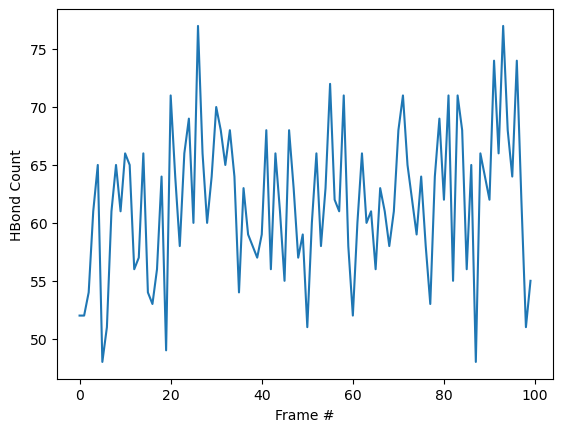

In [19]:
counts = h.count_by_time()
plt.plot(h.frames,h.count_by_time())
plt.xlabel("Frame #"); plt.ylabel("HBond Count");

Actually, what I'm *really* interested in is comparing SHMT2 and SHMT1...

In [21]:
!wget https://asinansaglam.github.io/python_bio_2022/files/shmt1.prmtop
!wget https://asinansaglam.github.io/python_bio_2022/files/shmt1.dcd

--2023-10-11 22:24:38--  https://asinansaglam.github.io/python_bio_2022/files/shmt1.prmtop
Resolving asinansaglam.github.io (asinansaglam.github.io)... 2606:50c0:8001::153, 2606:50c0:8002::153, 2606:50c0:8003::153, ...
Connecting to asinansaglam.github.io (asinansaglam.github.io)|2606:50c0:8001::153|:443... connected.
Unable to establish SSL connection.
--2023-10-11 22:24:39--  https://asinansaglam.github.io/python_bio_2022/files/shmt1.dcd
Resolving asinansaglam.github.io (asinansaglam.github.io)... 2606:50c0:8001::153, 2606:50c0:8002::153, 2606:50c0:8003::153, ...
Connecting to asinansaglam.github.io (asinansaglam.github.io)|2606:50c0:8001::153|:443... connected.
Unable to establish SSL connection.


## Project

Compare the loop regions (resid 368:383 in SHMT2 vs resid 377:392 in SHMT1)
 * Compare the backbone RMSDs
 * Compare the hydrogen bonding patterns 
 * Compare the native contacts 

In [22]:
shmt1 = MDAnalysis.Universe('shmt1.prmtop', 'shmt1.dcd')
prot1 = shmt1.select_atoms('protein')

OSError: DCD file does not exist

In [ ]:
prot1.select_atoms('name CA and resid 377:392').resnames

In [ ]:
prot.select_atoms('name CA and resid 368:383').resnames

In [ ]:
import MDAnalysis
shmt2 = MDAnalysis.Universe('shmt2.prmtop','shmt2.dcd')
shmt1 = MDAnalysis.Universe('shmt1.prmtop','shmt1.dcd')
shmt2loopbackbone = shmt2.select_atoms('name CA and resid 368:383')
shmt1loopbackbone = shmt1.select_atoms('name CA and resid 377:392')
ref1 = shmt1loopbackbone.positions
ref2 = shmt2loopbackbone.positions
from MDAnalysis.analysis.rms import rmsd
rmsds1 = []
rmsds2 = []
for ts in shmt1.trajectory:
    rmsds1.append(rmsd(ref1,shmt1loopbackbone.positions))
for ts in shmt2.trajectory:
    rmsds2.append(rmsd(ref2,shmt2loopbackbone.positions))
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(rmsds1,label='shmt1',linewidth=3)
plt.plot(rmsds2,'--',label='shmt2',linewidth=3)
plt.xlabel('Frame')
plt.ylabel('RMSD)')
plt.legend(loc='best');

In [ ]:
h1 = HydrogenBondAnalysis(shmt1,'resid 377:392','protein')
h1.run();
h2 = HydrogenBondAnalysis(shmt2,'resid 368:383','protein')
h2.run();
plt.plot(h1.count_by_time(),'-',label='shmt1',linewidth=2)
plt.plot(h2.count_by_time(),'--',label='shmt2',linewidth=2)
plt.xlabel('Frame'); plt.ylabel('HBonds')
plt.legend();

In [ ]:
loop1 = shmt1.select_atoms('resid 377:392')
prot1 = shmt1.select_atoms('protein')
CA1 = Contacts(shmt1, select=('resid 377:392','protein'), refgroup=(loop1, prot1),method='soft_cut')
CA1.run()
loop2 = shmt2.select_atoms('resid 368:383')
prot2 = shmt2.select_atoms('protein')
CA2 = Contacts(shmt2, select=('resid 368:383','protein'), refgroup=(loop2, prot2),method='soft_cut')
CA2.run()
plt.plot(CA1.results.timeseries[:, 0], CA1.results.timeseries[:, 1],label="shmt1")
plt.plot(CA2.results.timeseries[:, 0], CA2.results.timeseries[:, 1],label="shmt2")
plt.legend(loc='best')
plt.xlabel("Frame"); plt.ylabel("Fraction native contacts");